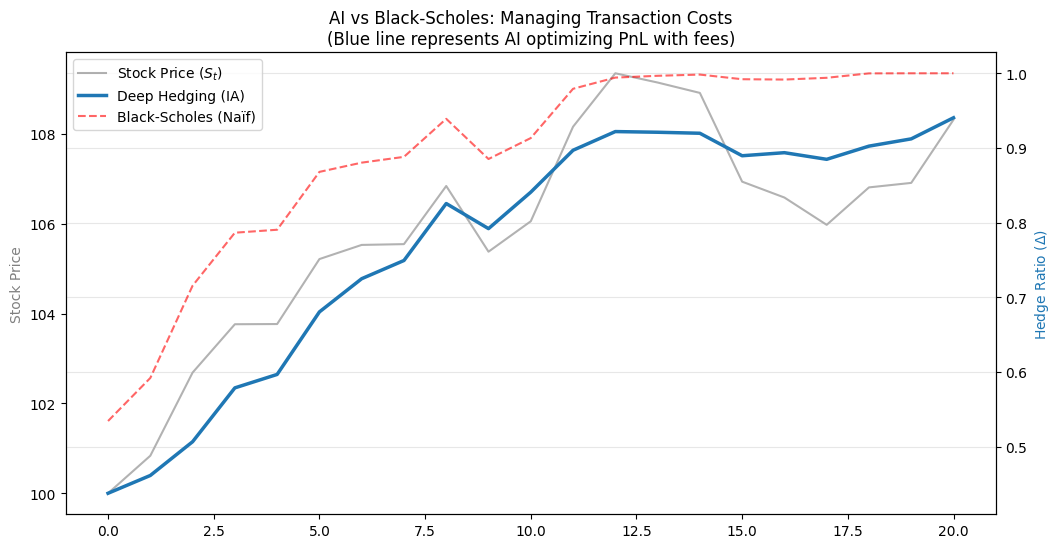

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.stats import norm
sys.path.append(os.path.abspath('..'))
from src.simulator import HestonSimulator
from src.modeldeeplearning import DeepHedger

model = DeepHedger()
try:
  
    model.load_state_dict(torch.load("../deep_hedger.pth"))
except:
    print("f")

sim = HestonSimulator(T=1/12)
S, v = sim.simulate_paths(1) 

# Deep Hedging VS BS
deltas_deep = []
S_path = S[0]
v_path = v[0]
prev_d = torch.zeros(1,1) 

# Black-Scholes
K = 100
T = 1/12

with torch.no_grad():
    for t in range(sim.N_steps):
        curr_S = torch.tensor([[S_path[t]]]).float()
        curr_v = torch.tensor([[v_path[t]]]).float()
        time_left = torch.tensor([[T - t*sim.dt]]).float()
        

    
        features = torch.cat([torch.log(curr_S/K)*100, time_left*100, curr_v*100, prev_d], dim=1)
        

        d = model(features)
        deltas_deep.append(d.item())
        prev_d = d 

plt.figure(figsize=(12, 6))


ax1 = plt.gca()
ax1.plot(S_path[:-1], color='black', alpha=0.3, label='Stock Price ($S_t$)')
ax1.set_ylabel("Stock Price", color='gray')


ax2 = ax1.twinx()
# IA (Bleu)
ax2.plot(deltas_deep, color='#1f77b4', linewidth=2.5, label='Deep Hedging (IA)')

from scipy.stats import norm
d1 = (np.log(S_path[:-1]/K) + (0.04 + 0.5*v_path[:-1])*np.linspace(T, 0, sim.N_steps)) / (np.sqrt(v_path[:-1])*np.sqrt(np.linspace(T, 0.001, sim.N_steps)))
bs_delta = norm.cdf(d1)
ax2.plot(bs_delta, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Black-Scholes (Naïf)')

ax2.set_ylabel("Hedge Ratio ($\Delta$)", color='#1f77b4')
plt.title("AI vs Black-Scholes: Managing Transaction Costs\n(Blue line represents AI optimizing PnL with fees)")


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.show()

Strategy comparison in progress...
Initial premium received: 2.3030


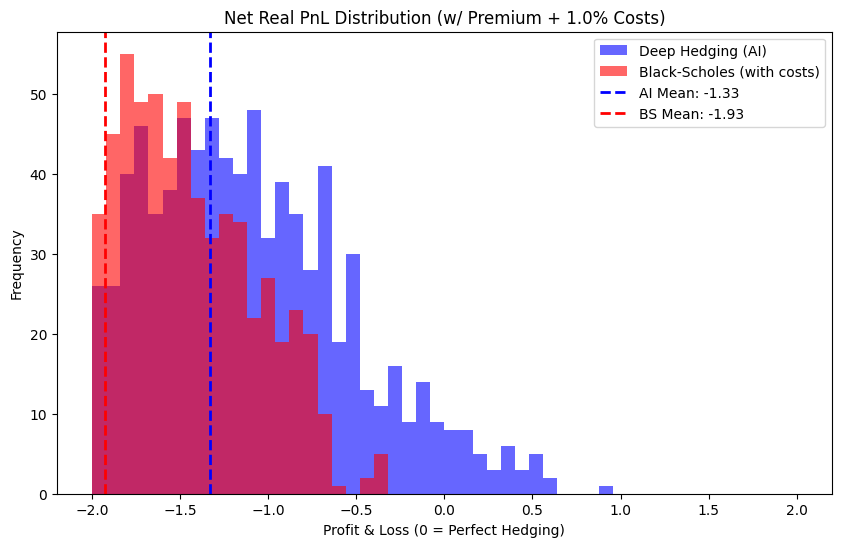

In [ ]:

n_test_paths = 1000
cost_rate = 0.01  # Same cost as training
K = 100
T = 1/12


S_test, v_test = sim.simulate_paths(n_test_paths)
S_tensor = torch.FloatTensor(S_test)
v_tensor = torch.FloatTensor(v_test)


pnl_ai = np.zeros(n_test_paths)
pnl_bs = np.zeros(n_test_paths)


prev_delta_ai = torch.zeros(n_test_paths, 1)
prev_delta_bs = np.zeros(n_test_paths)

print("Strategy comparison in progress...")

with torch.no_grad():
    for t in range(sim.N_steps):
        # data
        curr_S = S_tensor[:, t].unsqueeze(1)
        curr_v = v_tensor[:, t].unsqueeze(1)
        time_left = torch.full((n_test_paths, 1), T - t*sim.dt)
        

        features = torch.cat([torch.log(curr_S/K)*100, time_left*100, curr_v*100, prev_delta_ai], dim=1)
        delta_ai = model(features)
        
        # AI Costs
        trade_size_ai = torch.abs(delta_ai - prev_delta_ai)
        cost_ai = trade_size_ai.squeeze() * curr_S.squeeze() * cost_rate
        
        # AI Gain 
        price_change = S_tensor[:, t+1] - S_tensor[:, t]
        pnl_ai += (delta_ai.squeeze().numpy() * price_change.numpy()) - cost_ai.numpy()
        
        prev_delta_ai = delta_ai

       
        t_val = max(T - t*sim.dt, 1e-5)
        d1 = (np.log(curr_S.numpy().flatten()/K) + (0.04 + 0.5*curr_v.numpy().flatten())*t_val) / (np.sqrt(curr_v.numpy().flatten())*np.sqrt(t_val))
        delta_bs = norm.cdf(d1)
        
    
        trade_size_bs = np.abs(delta_bs - prev_delta_bs)
        cost_bs = trade_size_bs * curr_S.numpy().flatten() * cost_rate
        
        pnl_bs += (delta_bs * price_change.numpy()) - cost_bs
        
        prev_delta_bs = delta_bs


final_payoff = np.maximum(S_test[:, -1] - K, 0)
pnl_ai -= final_payoff
pnl_bs -= final_payoff


r = 0.0      # Risk-free rate (same as simulator)
S0 = 100     # Initial Price
v0 = 0.04    
sigma0 = np.sqrt(v0) # Volatility

# Black-Scholes formula
d1_0 = (np.log(S0/K) + (r + 0.5*v0)*T) / (sigma0*np.sqrt(T))
d2_0 = d1_0 - sigma0*np.sqrt(T)
premium = S0 * norm.cdf(d1_0) - K * np.exp(-r*T) * norm.cdf(d2_0)

print(f"Initial premium received: {premium:.4f}")

pnl_ai += premium
pnl_bs += premium

plt.figure(figsize=(10, 6))


plt.hist(pnl_ai, bins=50, alpha=0.6, label='Deep Hedging (AI)', color='blue', range=(-2, 2))
plt.hist(pnl_bs, bins=50, alpha=0.6, label='Black-Scholes (with costs)', color='red', range=(-2, 2))

plt.axvline(np.mean(pnl_ai), color='blue', linestyle='dashed', linewidth=2, label=f'AI Mean: {np.mean(pnl_ai):.2f}')
plt.axvline(np.mean(pnl_bs), color='red', linestyle='dashed', linewidth=2, label=f'BS Mean: {np.mean(pnl_bs):.2f}')

plt.title(f"Net Real PnL Distribution (w/ Premium + {cost_rate*100}% Costs)")
plt.xlabel("Profit & Loss (0 = Perfect Hedging)")
plt.ylabel("Frequency")
plt.legend()
plt.show()